In [1]:
import numpy as np 
import pandas as pd 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.decomposition import PCA

from sklearn.impute import SimpleImputer, KNNImputer

pd.set_option("display.max_columns", None)

In [2]:
def flattenColumnIndex(columns: list) -> list:
   return ['_'.join(col).strip() if col[1] != '' else col[0] for col in columns]

In [3]:
file = 'MotoGP_2021.csv'
data = pd.read_csv(file).drop('data', axis=1)

print(data.shape)
data.head()

(42741, 32)


,year,event,session,rider_position,rider_number,rider,nation,team,motorcycle,rider_classification,total_laps,full_laps,run_number,front_tire,rear_tire,front_tire_age,rear_tire_age,lap_invalidated,lap_unfinished,lap_number,lap_type,lap_time,T1,T2,T3,T4,speed,invalidated_T1,invalidated_T2,invalidated_T3,invalidated_T4,lap_time_seconds
0,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,0,0,False,False,1,Out,2'29.580,42.632,35.061,30.943,33.122,106.4,NaN,NaN,NaN,NaN,149.580
1,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,1,1,False,False,2,Speed,1'57.714,26.068,30.602,29.011,32.033,339.6,NaN,NaN,NaN,NaN,117.714
2,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,2,2,True,False,3,Speed,1'56.337,25.578,30.349,28.571,31.839,339.6,NaN,NaN,NaN,True,116.337
3,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,3,3,False,False,4,Speed,1'56.618,25.431,30.567,28.788,31.832,339.6,NaN,NaN,NaN,NaN,116.618
4,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,4,4,False,False,5,Speed,1'55.518,25.254,30.048,28.554,31.662,341.7,NaN,NaN,NaN,NaN,115.518


In [9]:
data.groupby(['year','event','session','rider','rider_number']).rider_position.min().reset_index()

,year,event,session,rider,rider_number,rider_position
0,2021,ALR,FP1,BAGNAIA Francesco (FBag),63,2
1,2021,ALR,FP1,BASTIANINI Enea (EBas),23,20
2,2021,ALR,FP1,BINDER Brad (BBin),33,15
3,2021,ALR,FP1,BRADL Stefan (SBra),6,21
4,2021,ALR,FP1,DOVIZIOSO Andrea (ADov),4,19
...,...,...,...,...,...,...
2747,2021,VAL,WUP,QUARTARARO Fabio (FQua),20,7
2748,2021,VAL,WUP,RINS Alex (ARin),42,3
2749,2021,VAL,WUP,ROSSI Valentino (VRos),46,16
2750,2021,VAL,WUP,VIÃ‘ALES Maverick (MViÃ±),12,10


In [14]:
timed_features = ["T1", "T2", "T3", "T4", "lap_time_seconds"]
categorical_features = None

scalerFunc = lambda X: (X - X.min()) / (X.max() - X.min()) * (1 - 0) + 0


def attachTarget(X):
    """
    Taking each race weekend, and for each record, attaching
    the final race position for that weekend for that rider
    """

    target = (
        X[(X.session == "RAC")][
            ["year", "event", "rider", "rider_number", "rider_position"]
        ]
        .drop_duplicates()
        .rename({"rider_position": "y"}, axis="columns")
    )

    X = X[(X.session != "RAC")].merge(
        target, on=["year", "event", "rider", "rider_number"]
    )

    return X


def tabulateAcrossSessions(X):
    """
    Takes the scaled sector & laptimes and melts it so I can avg & std
    all sector & laptimes in one agg, instead of an agg for all combinations
    """
    calced = (
        X.melt(
            id_vars=[
                "y",
                "year",
                "event",
                "session",
                "rider_position",
                "rider_number",
                "rider",
            ],
            value_vars=timed_features,
            var_name="sector",
            value_name="time",
        )
        .groupby(
            ["y", "year", "event", "session", "rider_position", "rider_number", "rider"]
        )
        .agg({"rider_position": ["min"]})
    )

    calced.columns = flattenColumnIndex(calced.columns)

    calced = calced.pivot_table(
        index=["y", "year", "event", "rider_number", "rider"],
        columns=["session"],
        values=["rider_position_min"],
    )

    calced.columns = flattenColumnIndex(calced.columns)

    calced.reset_index(inplace=True)

    return calced


def split_data(data):

    dropCols = ["year", "event", "rider_number", "rider", "y"]

    train = data[data.event != "VAL"]
    test = data[data.event == "VAL"]

    x_train = train.drop(dropCols, axis=1)
    y_train = train["y"]

    x_test = test.drop(dropCols, axis=1)
    y_test = test["y"]

    return x_train, x_test, y_train, y_test


attach_target = FunctionTransformer(attachTarget)
widen_data = FunctionTransformer(tabulateAcrossSessions)
split = FunctionTransformer(split_data)

preProcessPipeline = make_pipeline(
    attach_target,
    # widen_data,
    # split
)


# x_train, x_test, y_train, y_test = preProcessPipeline.fit_transform(data)


# OVR = Pipeline([
#     ('ImputeNans', KNNImputer()),
#     ('OVR', OneVsRestClassifier(SVC(), n_jobs=-1))
# ])

# logit = Pipeline([
#     ('ImputeNans', KNNImputer()),
#     ('LogisticRegression', LogisticRegression())
# ])

# lr = Pipeline([
#     ('ImputeNans', KNNImputer()),
#     ('LinearRegression', LinearRegression())
# ])

# tst = Pipeline([
#     ('ImputeNans', KNNImputer()),
#     ('PCA', PCA())
#     ])

df = preProcessPipeline.fit_transform(data)


In [15]:
df.groupby(['year','event','session','rider','rider_number'

,year,event,session,rider_position,rider_number,rider,nation,team,motorcycle,rider_classification,total_laps,full_laps,run_number,front_tire,rear_tire,front_tire_age,rear_tire_age,lap_invalidated,lap_unfinished,lap_number,lap_type,lap_time,T1,T2,T3,T4,speed,invalidated_T1,invalidated_T2,invalidated_T3,invalidated_T4,lap_time_seconds,y
0,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,0,0,False,False,1,Out,2'29.580,42.632,35.061,30.943,33.122,106.4,NaN,NaN,NaN,NaN,149.580,18
1,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,1,1,False,False,2,Speed,1'57.714,26.068,30.602,29.011,32.033,339.6,NaN,NaN,NaN,NaN,117.714,18
2,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,2,2,True,False,3,Speed,1'56.337,25.578,30.349,28.571,31.839,339.6,NaN,NaN,NaN,True,116.337,18
3,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,3,3,False,False,4,Speed,1'56.618,25.431,30.567,28.788,31.832,339.6,NaN,NaN,NaN,NaN,116.618,18
4,2021,QAT,FP1,1,21,MORBIDELLI Franco (FMor),ITA,Petronas Yamaha SRT,YAMAHA,*,17,11,1,Slick-Hard,Slick-Hard,4,4,False,False,5,Speed,1'55.518,25.254,30.048,28.554,31.662,341.7,NaN,NaN,NaN,NaN,115.518,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32354,2021,GBR,WUP,20,96,ROSSI Valentino (VRos),ITA,Petronas Yamaha SRT,YAMAHA,*,11,6,1,Slick-Soft,Slick-Medium,12,12,False,False,13,Speed,2'02.165,24.150,39.292,27.902,30.821,324.3,NaN,NaN,NaN,NaN,122.165,19
32355,2021,GBR,WUP,20,96,ROSSI Valentino (VRos),ITA,Petronas Yamaha SRT,YAMAHA,*,11,6,1,Slick-Soft,Slick-Medium,13,13,False,False,14,Speed,2'02.613,24.115,39.241,28.134,31.123,320.4,NaN,NaN,NaN,NaN,122.613,19
32356,2021,GBR,WUP,20,96,ROSSI Valentino (VRos),ITA,Petronas Yamaha SRT,YAMAHA,*,11,6,1,Slick-Soft,Slick-Medium,14,14,False,False,15,Speed,2'02.371,24.093,39.223,28.128,30.927,320.4,NaN,NaN,NaN,NaN,122.371,19
32357,2021,GBR,WUP,20,96,ROSSI Valentino (VRos),ITA,Petronas Yamaha SRT,YAMAHA,*,11,6,1,Slick-Soft,Slick-Medium,15,15,True,False,16,Speed,2'01.975,24.015,39.098,27.989,30.873,320.4,NaN,NaN,True,NaN,121.975,19


In [12]:

OVR_model = OVR.fit(x_train, y_train)
y_pred_ovr = OVR.predict(x_test)

logit_model = logit.fit(x_train, y_train)
y_pred_logit = logit.predict(x_test)

lr_model = lr.fit(x_train, y_train)
y_pred_lr = lr.predict(x_test)


pca = tst.fit(x_train, y_train)

/Users/cameronboy/opt/anaconda3/envs/py3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


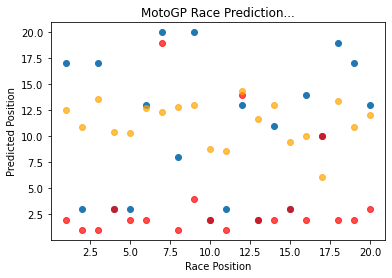

In [6]:
import matplotlib.pyplot as plt

plt.scatter(y_test.to_numpy(), y_pred_ovr)
plt.scatter(y_test.to_numpy(), y_pred_logit, color='red', alpha=.7)
plt.scatter(y_test.to_numpy(), y_pred_lr, color='orange', alpha=.7)
plt.xlabel("Race Position")
plt.ylabel("Predicted Position")
plt.title("MotoGP Race Prediction...")
plt.show()

